<a href="https://colab.research.google.com/github/dcromp/AICar_ir_remote/blob/master/sausage_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and stuff

In [0]:
%%capture
!echo "deb http://downloads.skewed.de/apt/bionic bionic universe" >> /etc/apt/sources.list
!echo "deb-src http://downloads.skewed.de/apt/bionic bionic universe" >> /etc/apt/sources.list
!cat /etc/apt/sources.list

# Debian
#!echo "deb http://downloads.skewed.de/apt/stretch stretch main" >> /etc/apt/sources.list
#!echo "deb-src http://downloads.skewed.de/apt/stretch stretch main" >> /etc/apt/sources.list
#!cat /etc/apt/sources.list
#!apt-get install dirmngr
#!apt-key adv --keyserver pgp.skewed.de --recv-key 612DEFB798507F25
#!apt-get update
#!apt-get install python3-graph-tool

In [0]:
!sudo apt-get install aptitude
!sudo aptitude install libboost-all-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-locale-perl libfcgi-perl
  libhtml-parser-perl libhtml-tagset-perl libhttp-date-perl
  libhttp-message-perl libio-html-perl libio-string

In [0]:
!apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 7A80C8ED4FCCBE09

Executing: /tmp/apt-key-gpghome.W1qLw7BKzQ/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 7A80C8ED4FCCBE09
gpg: key 612DEFB798507F25: 8 signatures not checked due to missing keys
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [0]:
%%capture
!apt-get update
!apt-get install python3-graph-tool

In [0]:
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  556k  100  556k    0     0   814k      0 --:--:-- --:--:-- --:--:--  813k


In [0]:
import os
os.chdir('spatialindex-src-1.8.5')

In [0]:
%%capture
!./configure
!make
!make install
!pip install rtree
!ldconfig

In [0]:
os.chdir('/content')

In [0]:
from rtree import index
from rtree.index import Rtree
import rtree
import collections

In [0]:
!pip install osmium

     |████████████████████████████████| 1.2MB 2.8MB/s 


In [150]:
import graph_tool.all as gt
from math import radians, sin, cos, sqrt, asin
from graph_tool.all import *
import pandas as pd
import osmium
from collections import defaultdict 
from google.colab import drive
from tqdm import tqdm
!pip install utm
import utm
import copy
import pickle
import numpy as np
from scipy.spatial import cKDTree
import shapely.wkt as wkt
from shapely.geometry import Point, Polygon
from shapely.ops import cascaded_union
import scipy.stats
import time
import random
from shapely.geometry import Point, LineString
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#!wget https://download.geofabrik.de/europe/norway-latest.osm.pbf

In [0]:
!cp -f gdrive/"My Drive"/norway-latest.osm.pbf norway-latest.osm.pbf

# Graph Maker

In [0]:
class GraphMaker():
  """
  Loads lookup dicts into graph-tool and saves results
  """
  def __init__(self, name, node2loc, way2nodes, way_weights, way2oneway):
    self.name = name
    self.g = Graph(directed=True)  # Graph tool object
    self.add_vertices(node2loc)
    self.add_edges(way2nodes, way_weights, way2oneway)
    self.save_graph()
    

  def haversine(self, lat1, lon1, lat2, lon2):
    R = 6372.8  # Earth radius in kilometers
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    a = sin(dLat / 2)**2 + cos(lat1) * cos(lat2) * sin(dLon / 2)**2
    c = 2 * asin(sqrt(a))
    return R * c
    

  def add_vertices(self, node2loc):
    counter = 0
    total = len(node2loc)
    print("Adding vertices")
    print("Number of vertices to add: ", total)
    self.node2veridx = {}
    pos = self.g.new_vertex_property("vector<double>")
    name = self.g.new_vertex_property("string")
    
    for index, node in enumerate(list(node2loc)):
      
      # Keep track of time
      if index % 100000 == 0:
        print("Number of vertices processed: ", counter)
        print("Percentage: ", counter/total)
      counter += 1
        
      loc = node2loc[node]
      v = self.g.add_vertex()
      self.node2veridx[node] = self.g.vertex_index[v]
      pos[v] = loc
      name[v] = node
    self.g.vp.pos = pos
    self.g.vp.name = name

    
  def add_edges(self, way2nodes, way_weights, way2oneway=None):
    counter = 0
    total = len(way2nodes)
    # Graph properties
    dis = self.g.new_edge_property("double")
    w_dis = self.g.new_edge_property("double")
    #e_name = self.g.new_edge_property("int")
    #direction = self.g.new_vertex_property("string")
    
    print("Adding edges from ways")
    print("Number of ways to add: ", total)
    
    for index, way in enumerate(way2nodes):
      # Keep track of time
      if index % 10000 == 0:
        print("Number of ways processed: ", counter)
        print("Percentage: ", counter/total)
      ww = way_weights[way]
      
      if way2oneway is not None:
        oneway = way2oneway[way] 
      else:
        oneway = None
     
      nodes = way2nodes[way]
      n_length = len(nodes)
      if n_length == 1:
        continue
      for i in range(n_length):
        # From and to vertices
        from_node = nodes[i]
        to_node = nodes[i+1]
        from_v = self.node2veridx[from_node]
        to_v = self.node2veridx[to_node]
        
        # Haversine distance
        from_lon_lat = self.g.vp.pos[from_v]
        to_lon_lat = self.g.vp.pos[to_v]
        d = self.haversine(from_lon_lat[1], from_lon_lat[0], to_lon_lat[1], to_lon_lat[0])
        w_d = d*ww
        
        # Add edges
        if oneway == True:
          e = self.g.add_edge(from_v, to_v)
          dis[e] = d
          w_dis[e] = w_d
        
          #e_name[e] = way
          
        else:
          e1 = self.g.add_edge(from_v, to_v)
          e2 = self.g.add_edge(to_v, from_v)
          dis[e1] = d
          w_dis[e1] = w_d
          #e_name[e1] = way
          #direction[e1] = 'F'
          
          dis[e2] = d
          w_dis[e2] = w_d
          #e_name[e2] = way
          #direction[e2] = 'B'
          
        if i+1 == n_length-1:
            break
      counter += 1
    
    # Save properties
    self.g.ep.dis = dis
    self.g.ep.w_dis = w_dis
    #self.g.ep.e_name = e_name
    #self.g.ep.direction = direction
    
    
  def save_graph(self):
    pickle.dump(self.g, open("{}_graph.pkl".format(self.name), "wb" ))
    pickle.dump(self.node2veridx, open("{}_node2veridx.pkl".format(self.name), "wb" ))
    print("Everything done and saved")
      

# Road lookup tables

In [0]:
# Road Weights
road_w = {
    'railway': 1/90,
    'motorway': 1/90,
    'motorway_link': 1/90,
    'trunk': 1/90,
    'trunk_link': 1/90,
    'highway': 1/90,
    'highway_link': 1/90,
    'primary': 1/60, 
    'primary_link': 1/60,
    'secondary': 1/40,
    'secondary_link': 1/40,
    'tertiary':1/30,
    'unclassified':1/30,
    'residential':1/30
}

In [0]:
class RoadRef(osmium.SimpleHandler):
    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.way2nodes = defaultdict(list)
        self.nodes2ways = defaultdict(list)
        self.way_weights = {}
        self.way2oneway = {}

    def way(self, w):

        # Check for ferry
        if 'route' in w.tags:
          if w.tags['route'] == 'ferry':
            self.way2oneway[w.id] = False
            self.way_weights[w.id] = 1/30
            for n in w.nodes:
              self.nodes2ways[n.ref].append(w.id)
              self.way2nodes[w.id].append(n.ref)
            return
              
        # Check for roads     
        if 'highway' in w.tags:
          if w.tags['highway'] not in road_w:
            return
          
          road_type = w.tags['highway']
          
          if road_type in road_w:
            weight = road_w[road_type]
          else:
            weight = road_w['else']
            
          self.way_weights[w.id] = weight
          
          self.way2oneway[w.id] = False
          if 'oneway' in w.tags:
            if w.tags['oneway'] == 'yes':
              self.way2oneway[w.id] = True
        
          for n in w.nodes:
            self.nodes2ways[n.ref].append(w.id)
            self.way2nodes[w.id].append(n.ref)


In [0]:
h = RoadRef()
h.apply_file("norway-latest.osm.pbf")

In [0]:
pickle.dump(h.way2nodes, open("way2nodes.pkl", "wb" ))
!cp -f way2nodes.pkl gdrive/"My Drive"/way2nodes.pkl

pickle.dump(h.nodes2ways, open("nodes2ways.pkl", "wb" ))
!cp -f nodes2ways.pkl gdrive/"My Drive"/nodes2ways.pkl

pickle.dump(h.way_weights, open("way_weights.pkl", "wb" ))
!cp -f way_weights.pkl gdrive/"My Drive"/way_weights.pkl

pickle.dump(h.way2oneway, open("way2oneway.pkl", "wb" ))
!cp -f way2oneway.pkl gdrive/"My Drive"/way2oneway.pkl

In [0]:
way2nodes = h.way2nodes
nodes2ways = h.nodes2ways


# Make the ways more simple

new_way2nodes = {}
new_nodes2ways = defaultdict(list)

for key in way2nodes:  # Key is the way id
  way = way2nodes[key]  # List of nodes that make up the way
  length = len(way) - 1
  
  new_way = []
  
  for index, node in enumerate(way):
    
    if index == 0:
      new_way.append(node)
      new_nodes2ways[node].append(key)
      continue
      
    if index == length:
      new_way.append(node)
      new_nodes2ways[node].append(key)
      continue
    
    # Node is part of intersection, so keep it
    if len(nodes2ways[node]) >= 2:
      new_way.append(node)
      new_nodes2ways[node].append(key)
      continue
      
    else:
      continue
  
  new_way2nodes[key] = new_way
    

In [0]:
nodes2ways = pickle.load(open("nodes2ways.pkl", "rb" ) )
target_nodes = [node for node in nodes2ways]

In [0]:
class NodeLoc(osmium.SimpleHandler):
    def __init__(self, nodes):
      osmium.SimpleHandler.__init__(self)
      self.node2loc = {}
      self.nodes = nodes
        
    def node(self, n):
      if n.id in self.nodes:
        self.node2loc[n.id] = [n.location.lon, n.location.lat]

In [0]:
g = NodeLoc(set(target_nodes))
g.apply_file("norway-latest.osm.pbf")

pickle.dump(g.node2loc, open("node2loc.pkl", "wb" ))
!cp -f node2loc.pkl gdrive/"My Drive"/node2loc.pkl

In [0]:
target_nodes = [node for node in new_nodes2ways]
new_node2loc = {}

for node in target_nodes:
  new_node2loc[node] = g.node2loc[node]

In [0]:
# Tabke to write too
results_table = dataset_ref.table("road_map")
client.delete_table(results_table)
from google.cloud import bigquery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

project = 'insights-225413'
client = bigquery.Client(project=project)

dataset_ref = client.dataset("david", project="insights-225413")

schema = [
    bigquery.SchemaField("node", "INT64"),
    bigquery.SchemaField("point", "STRING")
]

data_ref = dataset_ref.table("road_map")
result_ref = bigquery.Table(data_ref, schema=schema)
results_table = client.create_table(result_ref)

NameError: ignored

In [0]:
rows_to_insert = []

for idx, i in  enumerate(new_node2loc):
  loc = new_node2loc[i]
  loc = "POINT({} {})".format(loc[0],loc[1])
  rows_to_insert.append((i, loc))
  if idx % 1000 == 0:
    errors = client.insert_rows(result_ref, rows_to_insert)
    rows_to_insert = []
errors = client.insert_rows(result_ref, rows_to_insert)    

In [0]:
print(len(g.node2loc))
print(len(new_node2loc))

6069489
425136


# Create Car Graph

In [0]:
!cp -f gdrive/"My Drive"/node2loc.pkl node2loc.pkl
node2loc = pickle.load(open("node2loc.pkl", "rb" ))

!cp -f gdrive/"My Drive"/way2nodes.pkl way2nodes.pkl
way2nodes = pickle.load(open("way2nodes.pkl", "rb" ))

!cp -f gdrive/"My Drive"/way_weights.pkl way_weights.pkl
way_weights = pickle.load(open("way_weights.pkl", "rb" ))

!cp -f gdrive/"My Drive"/way2oneway.pkl way2oneway.pkl
way2oneway = pickle.load(open("way2oneway.pkl", "rb" ))

In [0]:
a = GraphMaker("car", node2loc, way2nodes, way_weights, way2oneway)
!cp -f car_graph.pkl gdrive/"My Drive"/car_graph.pkl
!cp -f car_node2veridx.pkl gdrive/"My Drive"/car_node2veridx.pkl

Adding vertices
Number of vertices to add:  6069489
Number of vertices processed:  0
Percentage:  0.0
Number of vertices processed:  100000
Percentage:  0.016475851591460172
Number of vertices processed:  200000
Percentage:  0.032951703182920344
Number of vertices processed:  300000
Percentage:  0.04942755477438051
Number of vertices processed:  400000
Percentage:  0.06590340636584069
Number of vertices processed:  500000
Percentage:  0.08237925795730085
Number of vertices processed:  600000
Percentage:  0.09885510954876102
Number of vertices processed:  700000
Percentage:  0.11533096114022119
Number of vertices processed:  800000
Percentage:  0.13180681273168138
Number of vertices processed:  900000
Percentage:  0.14828266432314155
Number of vertices processed:  1000000
Percentage:  0.1647585159146017
Number of vertices processed:  1100000
Percentage:  0.18123436750606187
Number of vertices processed:  1200000
Percentage:  0.19771021909752204
Number of vertices processed:  1300000
Per

In [0]:
#a = GraphMaker("new", new_node2loc, new_way2nodes, way_weights, way2oneway)
#!cp -f new_graph.pkl gdrive/"My Drive"/new_graph.pkl
#!cp -f new_node2veridx.pkl gdrive/"My Drive"/new_node2veridx.pkl

In [0]:
# Load graph
!cp -f gdrive/"My Drive"/car_graph.pkl car_graph.pkl
g = pickle.load(open("car_graph.pkl", "rb" ))

In [0]:

# Vertex index to location
veridx2loc = {}
for index, v in enumerate(g.vertices()):
  loc = g.vp.pos[v]
  point = Point(loc[0], loc[1])
  veridx2loc[index] = point


# Simple Routing

In [0]:
# KD tree to find start and end node
nodes = np.array([veridx2loc[i].coords[0] for i in veridx2loc])
node_tree = cKDTree(nodes)

In [0]:
# String that defines a trip
line = """
LINESTRING(10.793490547729924 59.91024361792515,10.849505598703235 59.92497281195665,10.909288975226794 59.939545813975286,10.934910697670066 59.94049539608454,11.023844170148866 59.987543021377206,11.152767552344168 60.06206446330356,11.168532505700139 60.176058009952925,11.181117285531391 60.247560421500225,11.17181725489347 60.320965246111825,11.3052525944323 60.6188655794557,10.970420362193593 60.858397871837354,10.805945103100049 60.91530651920175,10.64039437369857 60.94715386523171,10.31641893594796 61.29477811542071,10.278164489675277 61.37591299253603,10.174696515223314 61.49534842697611,9.764024389707714 61.58168458220109,9.553987355851314 61.70018216101647,9.553164253387738 61.80912660833013,9.420711502967178 61.87501725513505,9.250618230648051 61.97901987639099,9.274571775037291 62.10855738639248,9.579022422107906 62.266653070584454,9.639844643149942 62.3829880376762,9.614975543587208 62.53178608046716,9.824164794785672 62.64318543730383,10.01933398904904 62.79542708028481,10.07152195318227 62.86696055154917,10.287690175015454 63.03261297079305,10.234545534414096 63.10067163327514,10.316174430076764 63.17766293774713,10.278080950199863 63.23607536361857,10.276624032062228 63.28792512450934,10.348670277109067 63.32700029885231,10.38476400654998 63.39416156810586)
"""

line = wkt.loads(line)

In [0]:
# Find start and end vertex of trip
locations = line.coords
start = locations[0]
end = locations[-1]

_, start_ii = node_tree.query(start, k=1)
_, end_ii = node_tree.query(end, k=1)

In [138]:
vlist, elist = gt.shortest_path(g, g.vertex(start_ii), g.vertex(end_ii), weights = g.ep.w_dis)
result = []
for i in vlist:
  pos = g.vp.pos[i]
  result.append(pos)

print(LineString(result).wkt)

LINESTRING (10.7934085 59.9103013, 10.7935039 59.9104468, 10.7936227 59.9105594, 10.7937573 59.9106687, 10.793925 59.9107753, 10.7941028 59.9108612, 10.7943874 59.9109789, 10.7947218 59.9110929, 10.7952948 59.9112822, 10.7978529 59.9121125, 10.7985538 59.9123549, 10.7992574 59.9125785, 10.7996374 59.9126938, 10.7999845 59.912782, 10.8003973 59.9128881, 10.8005829 59.9129293, 10.8016101 59.9131799, 10.8020032 59.9132778, 10.8023594 59.9133793, 10.8026109 59.9134653, 10.8028338 59.9135476, 10.8030491 59.9136297, 10.8036239 59.9138687, 10.8049514 59.914506, 10.8058916 59.9149659, 10.8073066 59.9156296, 10.8084353 59.9161684, 10.8091633 59.9165169, 10.8096576 59.9167451, 10.8098984 59.916855, 10.8102397 59.9170016, 10.8105068 59.9171034, 10.8107713 59.9172015, 10.8109844 59.9172753, 10.8111726 59.9173372, 10.8113989 59.9174089, 10.8116424 59.9174855, 10.8118516 59.917544, 10.8123853 59.9176887, 10.812884 59.9178219, 10.8137356 59.9180434, 10.8151751 59.9184209, 10.8159705 59.9186321, 10.81

# Include accuracy

In [0]:
locations = line.coords
# Pretend accuracies
acc = [0.006] * len(locations)

In [140]:
# Loop through pairs of points
locations = line.coords

for index, i in enumerate(locations):
  
  if index + 1 == len(locations):
    break
    
  first = i
  second = locations[index + 1]
  heading = LineString([first, second])
  
  # Draw polygon between the two points
  dilated = heading.buffer(acc[index])
  
  print(dilated.wkt, ",")

POLYGON ((10.84797976363946 59.93077555504576, 10.848555879236 59.9308971712413, 10.84914114115019 59.93096173261834, 10.84972991298984 59.93096861741554, 10.85031652456029 59.93091775932852, 10.85089532647144 59.93080964814848, 10.85146074454448 59.93064532504517, 10.85200733349428 59.93042637253991, 10.85252982937046 59.93015489926501, 10.85302320025209 59.92983351965651, 10.85348269470789 59.92946532877573, 10.85390388755507 59.92905387250212, 10.85428272247625 59.92860311338453, 10.85461555108406 59.92811739247966, 10.85489916805705 59.92760138754536, 10.85513084200875 59.92706006799121, 10.85530834179234 59.92649864702043, 10.85542995798788 59.92592253142388, 10.85549451936493 59.9253372695097, 10.85550140416212 59.92474849767004, 10.85545054607511 59.92416188609959, 10.85534243489507 59.92358308418844, 10.85517811179176 59.9230176661154, 10.85495915928649 59.9224710771656, 10.85468768601159 59.92194858128943, 10.8543663064031 59.92145521040779, 10.85399811552232 59.920995715952, 

### Elispe test

29.217716581782657
60.78228341821735


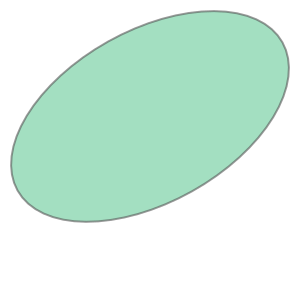

In [141]:
from matplotlib import pyplot
from shapely.geometry.point import Point
import shapely.affinity
from descartes import PolygonPatch
import utm
from math import sqrt, atan2
import math

PI = 3.14159265359

utm_loc = []
# Convert to UTM
for i in line.coords:
  x,y,_,_ = utm.from_latlon(i[1], i[0])
  utm_loc.append([x,y])
  

# Mid point
first = utm_loc[0]
second = utm_loc[1]


mid_x = (first[0] + second[0]) / 2
mid_y = (first[1] + second[1]) / 2

diameter = sqrt((second[0] - first[0])**2 + (second[1] - first[1])**2)

radians = atan2(second[1] - first[1], second[0] - first[0])
degrees = math.degrees(radians)
print(degrees)
degrees = 90 - degrees
print(degrees)


# 1st elem = center point (x,y) coordinates
# 2nd elem = the two semi-axis values (along x, along y)
# 3rd elem = angle in degrees between x-axis of the Cartesian base
#            and the corresponding semi-axis
ellipse = ((mid_x, mid_y),(diameter/2, 1000), degrees)

# Let create a circle of radius 1 around center point:
circ = shapely.geometry.Point(ellipse[0]).buffer(1)

# Let create the ellipse along x and y:
ell  = shapely.affinity.scale(circ, int(ellipse[1][0]), int(ellipse[1][1]))

# Let rotate the ellipse (clockwise, x axis pointing right):
ellr = shapely.affinity.rotate(ell,ellipse[2])

# If one need to rotate it clockwise along an upward pointing x axis:
elrv = shapely.affinity.rotate(ell,90-ellipse[2])
# According to the man, a positive value means a anti-clockwise angle,
# and a negative one a clockwise angle.


elrv

In [142]:
sasuage = [] 
for i in elrv.exterior.coords:
  lat, lon = utm.to_latlon(i[0], i[1], 32, 'V')
  sasuage.append((lon, lat))
sasuage = Polygon(sasuage)

print(sasuage.wkt, ",", "LINESTRING(10.793490547729924 59.91024361792515,10.849505598703235 59.92497281195665)")

POLYGON ((10.84950460169797 59.92497252783838, 10.85018232720936 59.92415734178234, 10.85058366838103 59.92327914109039, 10.85070478010296 59.92234638571849, 10.85054451909956 59.92136805926843, 10.85010445411748 59.92035358239534, 10.84938884980466 59.91931272216513, 10.84840462464955 59.91825549806069, 10.84716128327636 59.91719208572056, 10.84567082394545 59.91613271913202, 10.8439476220662 59.91508759236429, 10.84200829093636 59.91406676170482, 10.83987152103087 59.91308004917601, 10.83755789954907 59.91213694823291, 10.83508971168765 59.91124653278423, 10.83249072601124 59.91041737003303, 10.82978596551619 59.90965743835797, 10.82700146692951 59.90897405069609, 10.8241640303991 59.90837378435096, 10.82130096204248 59.90786241779254, 10.81843981167221 59.90744487513624, 10.81560810845766 59.90712517866476, 10.81283309666709 59.90690641016079, 10.81014147441249 59.90679068101255, 10.80755913748664 59.90677911176758, 10.80511093100092 59.90687182108679, 10.80282041103617 59.907067924

### Elsipe

In [149]:
PI = 3.14159265359

utm_loc = []
# Convert to UTM
for i in line.coords:
  x,y,_,_ = utm.from_latlon(i[1], i[0])
  utm_loc.append([x,y])
  

for index, i in enumerate(utm_loc):
  
  if index + 1 == len(utm_loc):
    break
    
  first = i
  second = utm_loc[index + 1]
  
  # Midpoint
  mid_x = (first[0] + second[0]) / 2
  mid_y = (first[1] + second[1]) / 2
  
  # distance and angle
  diameter = sqrt((second[0] - first[0])**2 + (second[1] - first[1])**2) + 647
  radians = atan2(second[1] - first[1], second[0] - first[0])
  degrees = math.degrees(radians)
  degrees = 90 - degrees
 
  
  ellipse = ((mid_x, mid_y),(diameter/2, diameter/2), degrees)
  circ = shapely.geometry.Point(ellipse[0]).buffer(1)
  ell  = shapely.affinity.scale(circ, int(ellipse[1][0]), int(ellipse[1][1]))
  ellr = shapely.affinity.rotate(ell,ellipse[2])
  elrv = shapely.affinity.rotate(ell,90-ellipse[2])
  
  sausage = [] 
  sausage = [] 
  for i in elrv.exterior.coords:
    lat, lon = utm.to_latlon(i[0], i[1], 32, 'V')
    sausage.append((lon, lat))
  sausage = Polygon(sausage)
  
  # Merge sausage

polygons = [poly1[0], poly1[1], poly2[0], poly2[1]]
boundary = gpd.GeoSeries(cascaded_union(polygons))
boundary.plot(color = 'red')
  
  print(sausage.wkt, ",")
  
print(line.wkt)
  


POLYGON ((10.85462361955049 59.92631673064136, 10.85616305046723 59.92464429616115, 10.85736837105768 59.92290415940399, 10.85822802059706 59.92111308783689, 10.85873377351339 59.91928833703438, 10.85888081664337 59.91744748414011, 10.85866779340259 59.91560825844995, 10.85809681443588 59.91378837072059, 10.85717343512079 59.91200534262449, 10.85590659985316 59.91027633819339, 10.85430855394146 59.90861799881969, 10.85239472393357 59.90704628338345, 10.85018356767827 59.90557631498305, 10.8476963955804 59.90422223579107, 10.84495716459658 59.90299707154193, 10.84199224763666 59.90191260643233, 10.83883017960096 59.90097927042776, 10.8355013835148 59.90020603916395, 10.83203787846604 59.89960034816981, 10.82847297295844 59.89916802152016, 10.82484094570427 59.89891321628018, 10.8211767177878 59.89883838248664, 10.81751551832902 59.89894423993667, 10.81389254762334 59.89922977114999, 10.81034264038758 59.8996922311097, 10.80689993241129 59.90032717354224, 10.80359753382072 59.90112849343

# Stuff

In [0]:
# String that defines a trip
line = """
LINESTRING(10.793490547729924 59.91024361792515,10.849505598703235 59.92497281195665)""" #,10.909288975226794 59.939545813975286,10.934910697670066 59.94049539608454,11.023844170148866 59.987543021377206,11.152767552344168 60.06206446330356,11.168532505700139 60.176058009952925,11.181117285531391 60.247560421500225,11.17181725489347 60.320965246111825,11.3052525944323 60.6188655794557,10.970420362193593 60.858397871837354,10.805945103100049 60.91530651920175,10.64039437369857 60.94715386523171,10.31641893594796 61.29477811542071,10.278164489675277 61.37591299253603,10.174696515223314 61.49534842697611,9.764024389707714 61.58168458220109,9.553987355851314 61.70018216101647,9.553164253387738 61.80912660833013,9.420711502967178 61.87501725513505,9.250618230648051 61.97901987639099,9.274571775037291 62.10855738639248,9.579022422107906 62.266653070584454,9.639844643149942 62.3829880376762,9.614975543587208 62.53178608046716,9.824164794785672 62.64318543730383,10.01933398904904 62.79542708028481,10.07152195318227 62.86696055154917,10.287690175015454 63.03261297079305,10.234545534414096 63.10067163327514,10.316174430076764 63.17766293774713,10.278080950199863 63.23607536361857,10.276624032062228 63.28792512450934,10.348670277109067 63.32700029885231,10.38476400654998 63.39416156810586)
#"""

line = "LINESTRING(10.76064896306054 59.90074790799997,10.77913973499991 59.901311804263116,10.797326677107542 59.91156575298385,10.811868959652374 59.91691412764877,10.801386830457336 59.92753086698531,10.784820314118985 59.93722124742132,10.775022451254404 59.95089719505478,10.755817549368636 59.95332680054082,10.733415942159173 59.950018150212514,10.714538241630661 59.94559656525112,10.705307787468945 59.94481427345397,10.68611327292785 59.93814095784873,10.711653156647213 59.9313648125717,10.726400589249375 59.922039739537354,10.734304060128874 59.91583176479779,10.734890945103006 59.91048126283005,10.74905019431295 59.90651599758593,10.76006207808641 59.90281917047841)"
line = wkt.loads(line)
 
# Polygon that surronds string

dilated = line.buffer(0.006)



In [0]:
# Loop through pairs of points
locations = line.coords
graphs = {}
prev_targets = []
all_dups = []
for index, i in enumerate(locations):
  
  if index + 1 == len(locations):
    break
    
  first = i
  second = locations[index + 1]
  heading = LineString([first, second])
  
  # Draw polygon between the two points
  dilated = heading.buffer(0.006)

  # Vertex inside polygon
  targets = []
  for key in veridx2loc:
    point = veridx2loc[key]
    if(point.within(dilated)):
      targets.append(key)
      
  
  if prev_targets:
    duplicates = []
    for j_idx, j in enumerate(targets):
      if j in prev_targets:

        current_idx = j_idx
        prev_idx = prev_targets.index(j)
        duplicates.append((prev_idx, current_idx,))
        
        
        
    all_dups.append(duplicates)
      
  # Create GraphView
  mask = g.new_vertex_property("bool")
  for i in targets:
    mask[i] = True
  graphs[index] = GraphView(g, vfilt=mask)
  
  prev_targets = targets
  
  
print(len(all_dups))
  
total_length = len(list(graphs[0].vertices()))
prev_length = total_length
prev_total = 0
prime_graph = graphs[0]



16


In [0]:
total_length = len(list(graphs[0].vertices()))
prev_length = total_length
prev_total = 0
prime_graph = graphs[0]


# Merge graphs
for index, i in enumerate(graphs):
  if index + 1 == len(graphs):
    break
    
    
  add_graph = graphs[index+1]
  length = len(list(add_graph.vertices()))
  prev_total = total_length
  total_length += length 
  
  
  # Merge graphs
  prime_graph = gt.graph_union(prime_graph, graphs[index+1], internal_props=True)
  
  
  # Get duplicated nodes
  dups = all_dups[index]
  
  
  for dup in dups:    
    from_dup = dup[0]
    to_dup = dup[1]
    
    
    from_dup = from_dup + (prev_total - prev_length)
    to_dup = to_dup + prev_total
    
    e = prime_graph.add_edge(from_dup, to_dup)
    prime_graph.ep.dis[e] = 0.
    prime_graph.ep.w_dis[e] = 0.
    

  prev_length = length
  

In [0]:
prime_graph

<Graph object, directed, with 3617 vertices and 8357 edges at 0x7f387c9bacf8>

In [0]:
vlist, elist = gt.shortest_path(prime_graph, prime_graph.vertex(101), prime_graph.vertex(3600))
result = []
for i in vlist:
  pos = prime_graph.vp.pos[i]
  result.append(pos)

print(LineString(result).wkt)

LINESTRING (10.7814064 59.9031684, 10.7816533 59.9032313, 10.7816615 59.9032802, 10.7817006 59.9032953, 10.7819321 59.9033586, 10.7823197 59.9033447, 10.7825195 59.9033365, 10.7832202 59.9033338, 10.7833889 59.9033192, 10.7837472 59.9032759, 10.7841439 59.9032922, 10.7844434 59.9035221, 10.7844434 59.9035221, 10.7847658 59.9046126, 10.7851548 59.9049546, 10.7856918 59.9053802, 10.7933533 59.9098692, 10.7933347 59.9099532, 10.7941028 59.9108612, 10.7952948 59.9112822, 10.7978529 59.9121125, 10.8005829 59.9129293, 10.8005829 59.9129293, 10.8036239 59.9138687, 10.8049514 59.914506, 10.8096576 59.9167451, 10.8107713 59.9172015, 10.8116424 59.9174855, 10.8118516 59.917544, 10.8114595 59.917295, 10.8092923 59.9183717, 10.8082518 59.920309, 10.8082518 59.920309, 10.8063544 59.9246429, 10.8038518 59.9259876, 10.8022366 59.9282485, 10.8022534 59.929569, 10.802144 59.9312149, 10.802144 59.9312149, 10.7964399 59.9342888, 10.7883938 59.9362142, 10.787771 59.9364415, 10.7834566 59.9384897, 10.78265

In [0]:
vlist, elist = gt.shortest_path(prime_graph, prime_graph.vertex(50), prime_graph.vertex(200))
result = []
for i in vlist:
  pos = prime_graph.vp.pos[i]
  result.append(pos)

print(LineString(result).wkt)

LINESTRING (10.7768681 59.9068265, 10.7780336 59.9066285, 10.777443 59.9064636, 10.7769425 59.9063187, 10.7767604 59.9062605, 10.7767115 59.9062355, 10.7769503 59.9060829, 10.7834799 59.9049333, 10.7837627 59.9048279, 10.7838924 59.9047566, 10.7840734 59.9046266, 10.7835058 59.9036275, 10.7832805 59.9034699, 10.7831839 59.9034281, 10.7831174 59.9034173, 10.7825195 59.9033365, 10.7823197 59.9033447, 10.7819321 59.9033586, 10.7815537 59.9033532, 10.7816528 59.9032981, 10.7816615 59.9032802, 10.7816533 59.9032313, 10.7814064 59.9031684, 10.7821683 59.9029462, 10.7817378 59.9023966, 10.776837 59.9007042, 10.7692117 59.8993105, 10.7624032 59.8998853)


In [0]:
prime_graph

<Graph object, directed, with 3617 vertices and 8357 edges at 0x7f789a165390>

In [0]:
gt.shortest_path(prime_graph, prime_graph.vertex(101), prime_graph.vertex(3400))

ValueError: ignored

In [0]:
prime_graph

<Graph object, directed, with 3617 vertices and 8357 edges at 0x7f789a18e6d8>

In [0]:
# Pick start and end point of trip
x = line.coords.xy[0]
y = line.coords.xy[1]
locations  = list(zip(x, y))

start_idx = ver_tree.query(locations[0], k=1)[1]
end_idx = ver_tree.query(locations[-1], k=1)[1]

# Shortest path
vlist, elist = gt.shortest_path(ug, ug.vertex(101), ug.vertex(3000))

NameError: ignored

In [0]:
len(list(ug.vertices()))

3617

In [0]:
for i in graphs:
  print(graphs[i])

<GraphView object, directed, with 273 vertices and 511 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f33fee108d0, at 0x7f33ff2e3a20>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f33fee108d0, at 0x7f33ff2e34e0>, False) at 0x7f33fee108d0>
<GraphView object, directed, with 313 vertices and 614 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f33fee10dd8, at 0x7f33d144b160>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f33fee10dd8, at 0x7f33d144b4e0>, False) at 0x7f33fee10dd8>
<GraphView object, directed, with 165 vertices and 278 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f33fee10550, at 0x7f33d144bcc0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f33fee10550, at 0x7f33d144be48>, False) at 0x7f33fee10550>
<GraphView object, 

In [0]:
prime_graph

<Graph object, directed, with 2525 vertices and 4820 edges at 0x7f33fe540f28>

In [0]:
locations = []
# Vertex inside polygon
targets = []
for key in veridx2loc:
  point = veridx2loc[key]
  if(point.within(dilated)):
      targets.append(key)   

  # Save
  x = point.coords.xy[0]
  y = point.coords.xy[1]
  locations.append(np.concatenate((x, y), axis=0))

       
ver_tree = cKDTree(np.array(locations)) 

In [0]:
# Filter graph with polygon
mask = g.new_vertex_property("bool")
for i in targets:
  mask[i] = True
g.set_vertex_filter(mask)

# Pick start and end point of trip
x = line.coords.xy[0]
y = line.coords.xy[1]
locations  = list(zip(x, y))

start_idx = ver_tree.query(locations[0], k=1)[1]
end_idx = ver_tree.query(locations[-1], k=1)[1]

# Shortest path
vlist, elist = gt.shortest_path(g, g.vertex(start_idx), g.vertex(end_idx))

#Done

In [0]:
result = []
for i in vlist:
  pos = g.vp.pos[i]
  result.append(pos)

print(LineString(result).wkt)

GEOMETRYCOLLECTION EMPTY


In [0]:
targets[-1]

425135

In [0]:
dilated.wkt

'POLYGON ((9.354780600246636 61.68443504403902, 9.331632072712686 61.69595063316005, 9.316380067111899 61.70438621607013, 9.146286794792772 61.80838883732607, 9.129708878025163 61.81970594590055, 9.114348833621463 61.83262776105, 9.100361377268936 61.84702412641166, 9.087887399115143 61.8627500330583, 9.077052544636901 61.87964708011616, 9.06796594906279 61.89754507027463, 9.060719138096912 61.91626372411686, 9.055385106016475 61.9356144960034, 9.052017580429125 61.95540247321834, 9.050650481095897 61.97542833924838, 9.051297578270789 61.99549038141977, 9.053952353998421 62.01538652267068, 9.077905898387661 62.14492403267217, 9.082574880685554 62.16456803323116, 9.089200724867769 62.18364116466081, 9.097715899311073 62.20194903067136, 9.10803361604755 62.2193050346759, 9.12004871532093 62.23553228161155, 9.133638737390999 62.25046538088112, 9.148665170662108 62.26395213203953, 9.164974863414669 62.27585507604414, 9.182401584751039 62.28605289625849, 9.430962163366354 62.41512588433536,